In [42]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from PIL import Image
from os import path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.ensemble import StackingClassifier

In [2]:
#import artists data there are six variables in this data set
artdf = pd.read_csv('E:/ZMR/ds5220data/artists-data.csv')
artdf.head(10)

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock
5,Aborto Elétrico,36,0.1,/aborto-eletrico/,Rock,Rock; Punk Rock; Pós-Punk; Post-Rock
6,Abril,36,0.1,/abril/,Rock,Rock; Emocore; Hardcore; Pop/Rock; Rock Altern...
7,Abuse,13,0.0,/abuse/,Rock,Rock; Hardcore
8,AC/DC,192,10.8,/ac-dc/,Rock,Rock; Heavy Metal; Classic Rock; Hard Rock; Cl...
9,ACEIA,0,0.0,/aceia/,Rock,Rock


In [3]:
artdf.shape

(3242, 6)

In [4]:
artdf['Genre'].value_counts()

Rock            797
Pop             796
Sertanejo       617
Hip Hop         537
Funk Carioca    302
Samba           193
Name: Genre, dtype: int64

In [5]:
# In this project, it onnly keep Link and Genre is fine
artdf=artdf[['Link','Genre']]
#drop duplicate Link variables
artdf.drop_duplicates(subset='Link',inplace=True)

In [6]:
#import lyric data set,there are five variables in this data set
ldf=pd.read_csv('E:/ZMR/ds5220data/lyrics-data.csv')
ldf.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


Because we want to merge two dataset into one using ALink as key. The first thing to do is to drop some duplicates.

In [7]:
#drop duplicates of ldf and only keep English songs
ldf.drop_duplicates(subset='SLink',inplace=True)
ldf.drop_duplicates(subset='Lyric',inplace=True)
ldf=ldf[ldf['Idiom']=='ENGLISH']

In [8]:
#merge two dataset
df=pd.merge(artdf, ldf, how='inner', left_on='Link', right_on='ALink')
del artdf
del ldf

In [9]:
df['Genre'].value_counts()

Rock            47408
Pop             25325
Hip Hop         13561
Sertanejo          43
Samba              40
Funk Carioca       14
Name: Genre, dtype: int64

In [10]:
#Just keep three types of music and two variables: Genre and Lyric
df=df[(df['Genre']=='Rock') | (df['Genre']=='Pop') | (df['Genre']=='Hip Hop')]
df=df[['Genre','Lyric']]

# Data Preprocessing and EDA

In [13]:
df.shape

(86294, 2)

In [11]:
#clean data with some Lyric with ryhme that not a Lyric
df=df[~df.Lyric.str.contains('[A-Z]-----------------',regex=True)]
df=df[~df.Lyric.str.contains('[0-9]---------------',regex=True)]
#Lower all the words
df['Lyric']=df['Lyric'].str.lower()
#replace all the it's i'am don't to it i don
df['Lyric']=df['Lyric'].str.replace("'[a-z]*", "",regex=True)


In [12]:
#vectorize and stem and caculate the words counts
tokenizer = RegexpTokenizer("[a-z]+")
ps=PorterStemmer()

df['new_text']=df.Lyric.apply(tokenizer.tokenize)


In [13]:
#stop_words = set(stopwords.words('english'))
df['new_text']=df['new_text'].apply(lambda x: [ps.stem(y) for y in x])

In [14]:
df['word_sum']=df['new_text'].apply(lambda x: len(x))

Text(0.5,1,'The distribution of Genres')

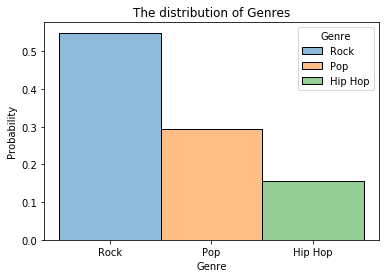

In [15]:
sns.histplot(data=df, x='Genre',hue='Genre',stat='probability').set_title('The distribution of Genres')

From the figure above, we can see that we needs to deal with inbalance problem when modeling

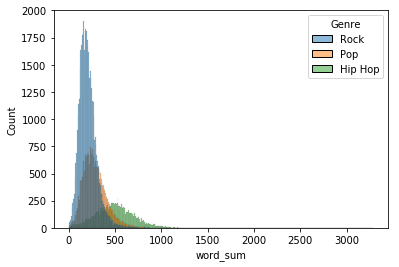

In [16]:
sns.histplot(data=df,x='word_sum',hue='Genre')

In [17]:
df['new_text']=df['new_text'].apply(lambda x: ' '.join(x))

In [18]:
df.to_csv('E:/ZMR/ds5220data/df.csv')

In [2]:
df=pd.read_csv('E:/ZMR/ds5220data/df.csv')

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
text_rock=' '.join(df['new_text'][df.Genre=='Rock'])
text_pop=' '.join(df['new_text'][df.Genre=='Pop'])
text_hip=' '.join(df['new_text'][df.Genre=='Hip Hop'])

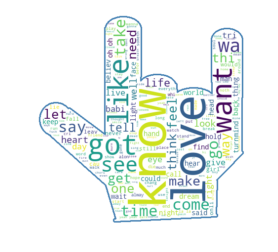

In [40]:
img = np.array(Image.open('E:/ZMR/ds5220data/rock.png'))
wordcloud = WordCloud(background_color='white',stopwords=stop_words,mask=img,max_words=200,
                      contour_width=3, contour_color='steelblue').generate(text_rock)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('E:/ZMR/ds5220data/rockwc.png')

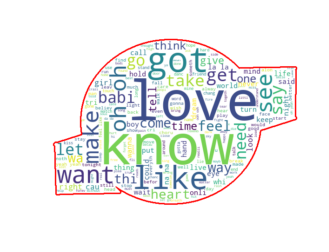

In [41]:
img = np.array(Image.open('E:/ZMR/ds5220data/pop.png'))
wordcloud = WordCloud(background_color='white',stopwords=stop_words,mask=img,max_words=200,
                      contour_width=3, contour_color='red').generate(text_pop)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('E:/ZMR/ds5220data/popwc.png')

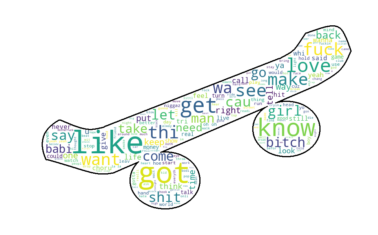

In [43]:
stop_words.add('nigga')
img = np.array(Image.open('E:/ZMR/ds5220data/hip.png'))
wordcloud = WordCloud(background_color='white',stopwords=stop_words,mask=img,max_words=200,
                      contour_width=3, contour_color='black').generate(text_hip)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('E:/ZMR/ds5220data/hipwc.png')

In [4]:
df['Genre'].replace('Hip Hop','1',inplace=True)
df['Genre'].replace('Pop','2',inplace=True)
df['Genre'].replace('Rock','3',inplace=True)
#split train and test data set
X_train,X_test,y_train,y_test=train_test_split(df['new_text'],df['Genre'],test_size=0.2,random_state=0)
#fit and transform into tfidf form
tfidf=TfidfVectorizer(stop_words=stop_words,max_features=5000)
text_train=tfidf.fit_transform(X_train).toarray()
text_test=tfidf.transform(X_test).toarray()
print(text_train.shape)

(68972, 5000)


In [5]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(text_train, y_train)
#print(sorted(Counter(y_resampled).items()))

In [6]:
y_resampled.value_counts()

3    10827
1    10827
2    10827
Name: Genre, dtype: int64

In [7]:
import gc
#deal with imbalanced data with Smote
X_train,X_val,y_train,y_val=train_test_split(X_resampled,y_resampled,test_size=0.2,random_state=0)
del X_resampled,df
gc.collect()

7

In [8]:
y_train.value_counts()

1    8671
3    8662
2    8651
Name: Genre, dtype: int64

In [12]:
def svm_c_tuning(X,y,X_val,y_val):
    t_acc=[]
    for i in np.arange(0.2,1,0.1):
        clf= OneVsOneClassifier(LinearSVC(random_state=0,C=i)).fit(X, y)
        t_acc.append(clf.score(X_val,y_val))
    return t_acc


In [13]:
r=np.arange(0.01,0.2,0.01)
acc2=svm_c_tuning(X_train,y_train,X_val,y_val)
r2=np.arange(0.01,0.2,0.01)

In [18]:
r2=np.arange(0.2,1,0.1)
r3=np.concatenate([r,r2])
acc3=np.concatenate([acc,acc2])

Text(0.5,1,'Distribution of score while C=0.01 to 1')

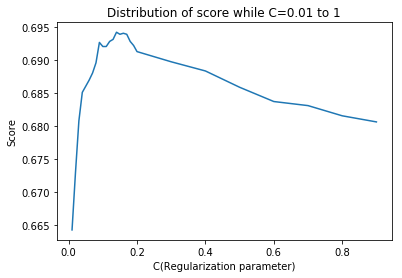

In [26]:
plt.plot(r3,acc3)
plt.xlabel('C(Regularization parameter)')
plt.ylabel('Score')
plt.title('Distribution of score while C=0.01 to 1')

Text(0.5,1,'Score can get the highest when C is around 0.130')

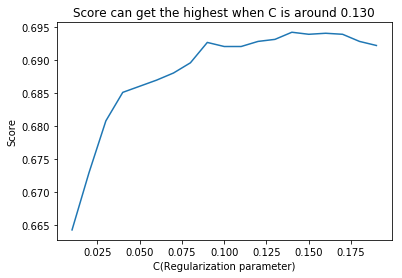

In [27]:
plt.plot(r,acc)
plt.xlabel('C(Regularization parameter)')
plt.ylabel('Score')
plt.title('Score can get the highest when C is around 0.130')

In [34]:
def rf_c_tuning(X,y,X_val,y_val,r):
    t_acc=[]
    for i in r:
        clf= RandomForestClassifier(n_estimators=i,max_depth=100).fit(X, y)
        t_acc.append(clf.score(X_val,y_val))
    return t_acc

In [31]:
acc_r=rf_c_tuning(X_train,y_train,X_val,y_val)


Text(0.5,1,'Distribution of score when n_estimators is from 50 to 175')

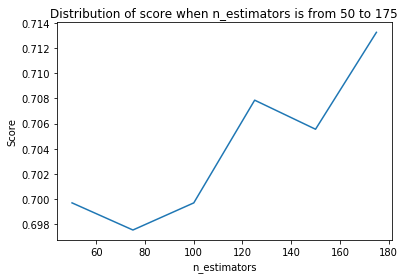

In [39]:
r_r=np.arange(50,200,25)
plt.plot(r_r,acc_r)
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('Distribution of score when n_estimators is from 50 to 175')

In [36]:
r_r2=np.arange(200,250,25)
acc_r2=rf_c_tuning(X_train,y_train,X_val,y_val,r_r2)

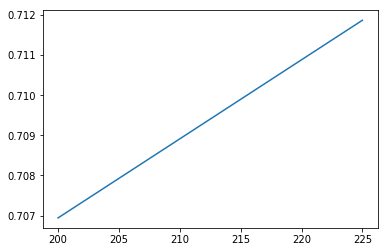

In [37]:
plt.plot(r_r2,acc_r2)

In [13]:
def lg_c_tuning(X,y,X_val,y_val,r):
    t_acc=[]
    for i in r:
        clf= OneVsOneClassifier(LogisticRegression(random_state=0,C=i)).fit(X, y)
        t_acc.append(clf.score(X_val,y_val))
    return t_acc

In [14]:
r_l=np.arange(0.5,5,0.5)
acc_lg=lg_c_tuning(X_train,y_train,X_val,y_val,r_l)


E:\an\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\an\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_

Text(0.5,1,'Distribution of score when C is from 0.5 to 5')

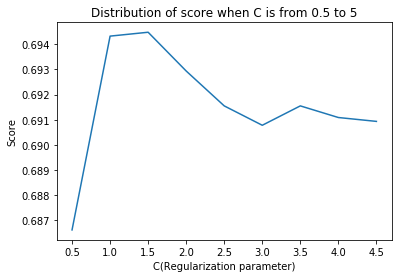

In [16]:
plt.plot(r_l,acc_lg)
plt.xlabel('C(Regularization parameter)')
plt.ylabel('Score')
plt.title('Distribution of score when C is from 0.5 to 5')

In [37]:
# From the hyperprameter tuning svm c=0.13 rf n=125 lg c=1.3

svm=LinearSVC(C=0.13,random_state=0)
rf=RandomForestClassifier(n_estimators=125,random_state=0)
lg=LogisticRegression(C=1.3)
def test(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(text_test)
    plot_confusion_matrix(model,text_test,y_test,display_labels=['Hip Hop','Pop','Rock'])
    print(classification_report(y_test, y_pred,target_names=['Hip Hop','Pop','Rock']))
    

              precision    recall  f1-score   support

     Hip Hop       0.76      0.80      0.78      2734
         Pop       0.50      0.58      0.54      5037
        Rock       0.78      0.71      0.74      9472

    accuracy                           0.68     17243
   macro avg       0.68      0.69      0.69     17243
weighted avg       0.70      0.68      0.69     17243



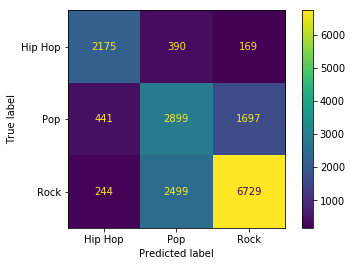

In [38]:
test(svm)

              precision    recall  f1-score   support

     Hip Hop       0.75      0.82      0.78      2734
         Pop       0.50      0.57      0.54      5037
        Rock       0.79      0.71      0.75      9472

    accuracy                           0.69     17243
   macro avg       0.68      0.70      0.69     17243
weighted avg       0.70      0.69      0.69     17243



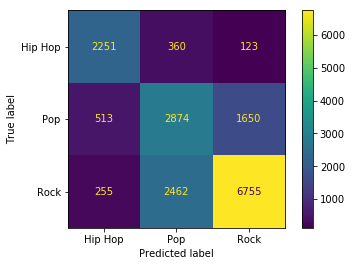

In [39]:
test(rf)

E:\an\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

     Hip Hop       0.76      0.79      0.78      2734
         Pop       0.49      0.59      0.54      5037
        Rock       0.79      0.69      0.74      9472

    accuracy                           0.68     17243
   macro avg       0.68      0.69      0.68     17243
weighted avg       0.70      0.68      0.69     17243



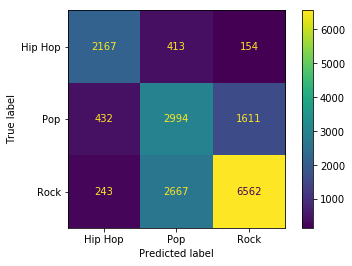

In [40]:
test(lg)

In [44]:
estimators = [('svm',LinearSVC(C=0.13,random_state=0)),('rf',RandomForestClassifier(n_estimators=125,random_state=0)),
    ('lg',LogisticRegression(C=1.3))
 ]
clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
)
clf.fit(X_train, y_train)

E:\an\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\an\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_

StackingClassifier(estimators=[('svm', LinearSVC(C=0.13, random_state=0)),
                               ('rf',
                                RandomForestClassifier(n_estimators=125,
                                                       random_state=0)),
                               ('lg', LogisticRegression(C=1.3))],
                   final_estimator=LogisticRegression())

In [45]:
y_e_pre=clf.predict(text_test)
print(classification_report(y_test, y_e_pre,target_names=['Hip Hop','Pop','Rock']))

              precision    recall  f1-score   support

     Hip Hop       0.78      0.82      0.80      2734
         Pop       0.52      0.61      0.56      5037
        Rock       0.81      0.72      0.76      9472

    accuracy                           0.70     17243
   macro avg       0.70      0.72      0.71     17243
weighted avg       0.72      0.70      0.71     17243



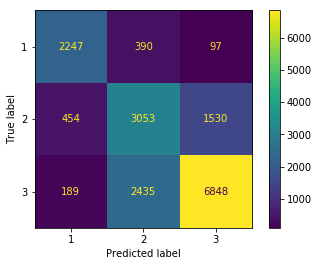

In [46]:
plot_confusion_matrix(clf,text_test,y_test)